In [107]:
import os
from typing import List
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers

from dataio import moon_distribution, custom_distribution, custom_laplace, custom_communication_system
from models import RealNVP
from callbacks import ShowProgress, LearningRateScheduler, BestModelWeights
import hyperparameters

from sklearn.utils import shuffle
import tensorflow_probability as tfp

In [108]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [139]:
x_distribution = tfp.distributions.MultivariateNormalDiag(loc=[0.0],scale_diag=[1.0])
noise_distribution = tfp.distributions.MultivariateNormalDiag(loc=[0.0],scale_diag=[1.0])

In [140]:
joint_data = []
marginal_data = []

for _ in range(100):
    x = x_distribution.sample(128)
    noise = noise_distribution.sample(128)
    y = x + noise

    batch_size = tf.shape(x)[0]
    x_tiled = tf.tile(x[None, :],  (batch_size, 1, 1))
    y_tiled = tf.tile(y[:, None],  (1, batch_size, 1))
    xy_pairs = tf.reshape(tf.concat((x_tiled, y_tiled), axis=2), [batch_size * batch_size, -1]).numpy()


    joint_buffer = xy_pairs.copy()
    marginal_buffer = np.stack([shuffle(xy_pairs[:,0]), shuffle(xy_pairs[:,1])], axis=-1)
    
    joint_data.append(shuffle(joint_buffer)[:128])
    marginal_data.append(marginal_buffer[:128])

joint_data = np.concatenate(joint_data, axis=0)
marginal_data = np.concatenate(marginal_data, axis=0)

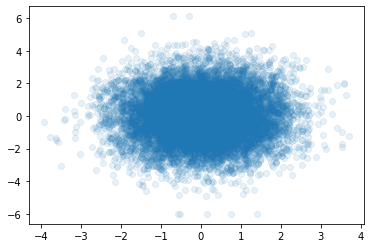

In [141]:
plt.scatter(marginal_data[:,0], marginal_data[:,1], alpha=0.1)

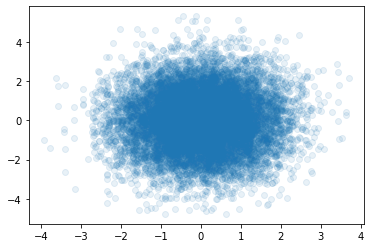

In [142]:
plt.scatter(joint_data[:,0], joint_data[:,1], alpha=0.1)

In [143]:
learningrate_scheduler = LearningRateScheduler()
show_progress = ShowProgress(hyperparameters.EPOCHS)
best_weight = BestModelWeights()

joint_model = RealNVP(n_variable=2, num_coupling_layers=6)

optimizer=keras.optimizers.Adam()
joint_model.compile(optimizer=optimizer)

joint_history = joint_model.fit(
    joint_data,
    batch_size=hyperparameters.BATCH_SIZE,
    epochs=hyperparameters.EPOCHS,
    verbose=0,
    validation_split=0.2,
    callbacks=[learningrate_scheduler, show_progress]
)

  0%|          | 0/150 [00:00<?, ?it/s]

In [144]:
learningrate_scheduler = LearningRateScheduler()
show_progress = ShowProgress(hyperparameters.EPOCHS)
best_weight = BestModelWeights()

marginal_model = RealNVP(n_variable=2, num_coupling_layers=6)

optimizer=keras.optimizers.Adam()
marginal_model.compile(optimizer=optimizer)

marginal_history = marginal_model.fit(
    marginal_data,
    batch_size=hyperparameters.BATCH_SIZE,
    epochs=hyperparameters.EPOCHS,
    verbose=0,
    validation_split=0.2,
    callbacks=[learningrate_scheduler, show_progress]
)

  0%|          | 0/150 [00:00<?, ?it/s]

(-6.0, 6.0)

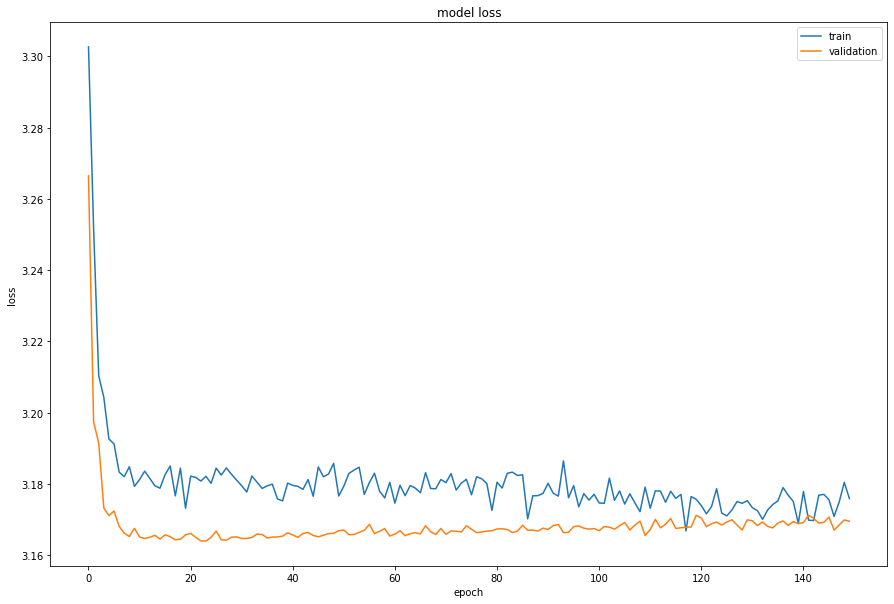

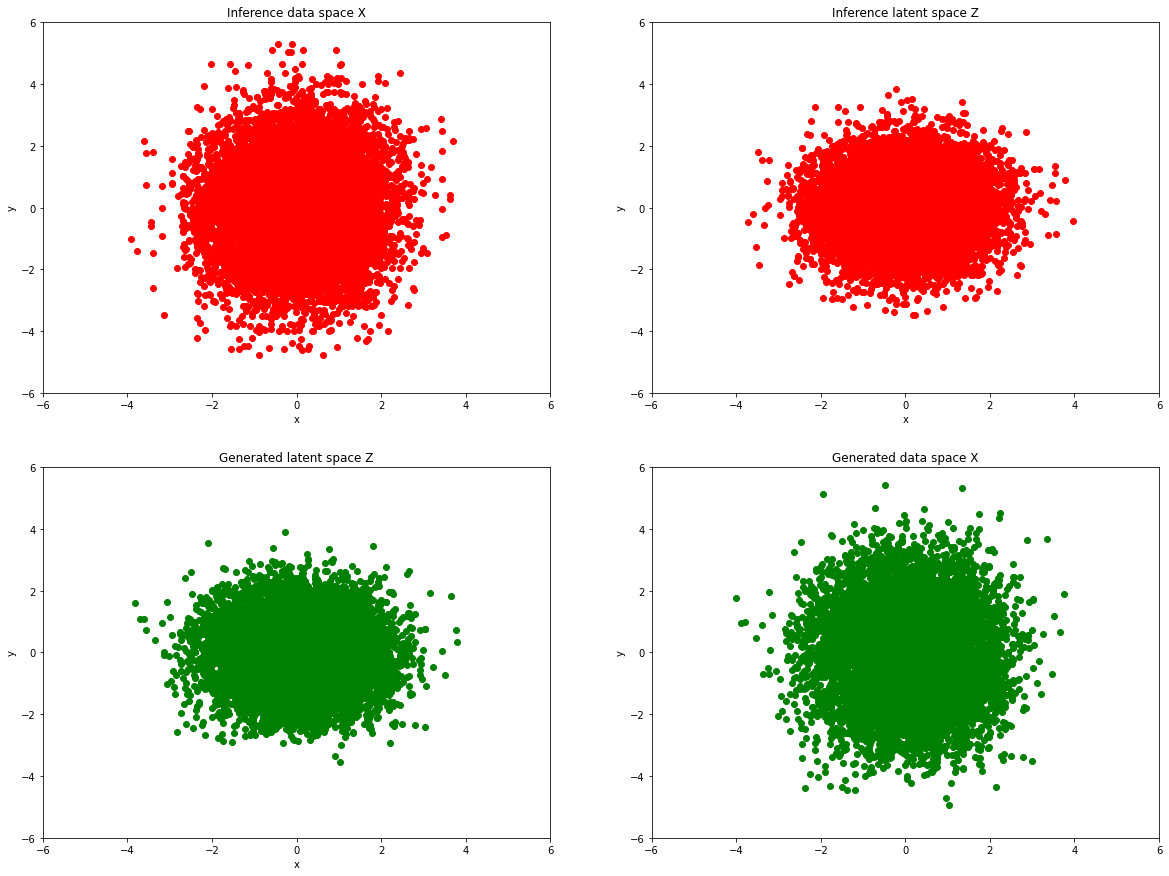

In [145]:
plt.figure(figsize=(15, 10))
plt.plot(joint_history.history["loss"])
plt.plot(joint_history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z, _ = joint_model(joint_data)

# From latent space to data.
samples = joint_model.distribution.sample(10000)
x, _ = joint_model.predict(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(joint_data[:, 0], joint_data[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 0].set_xlim([-6, 6])
axes[0, 0].set_ylim([-6, 6])
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-6, 6])
axes[0, 1].set_ylim([-6, 6])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 0].set_xlim([-6, 6])
axes[1, 0].set_ylim([-6, 6])
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-6, 6])
axes[1, 1].set_ylim([-6, 6])

(-6.0, 6.0)

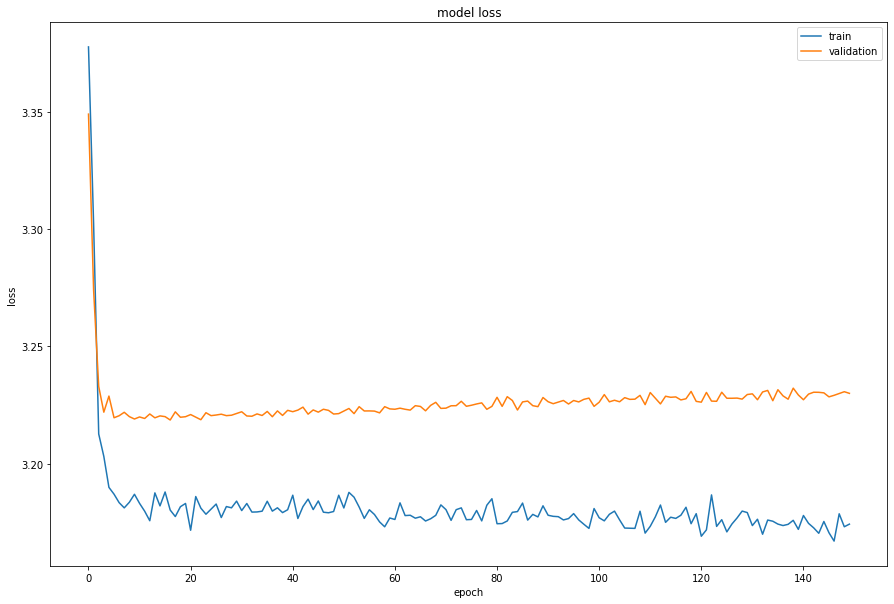

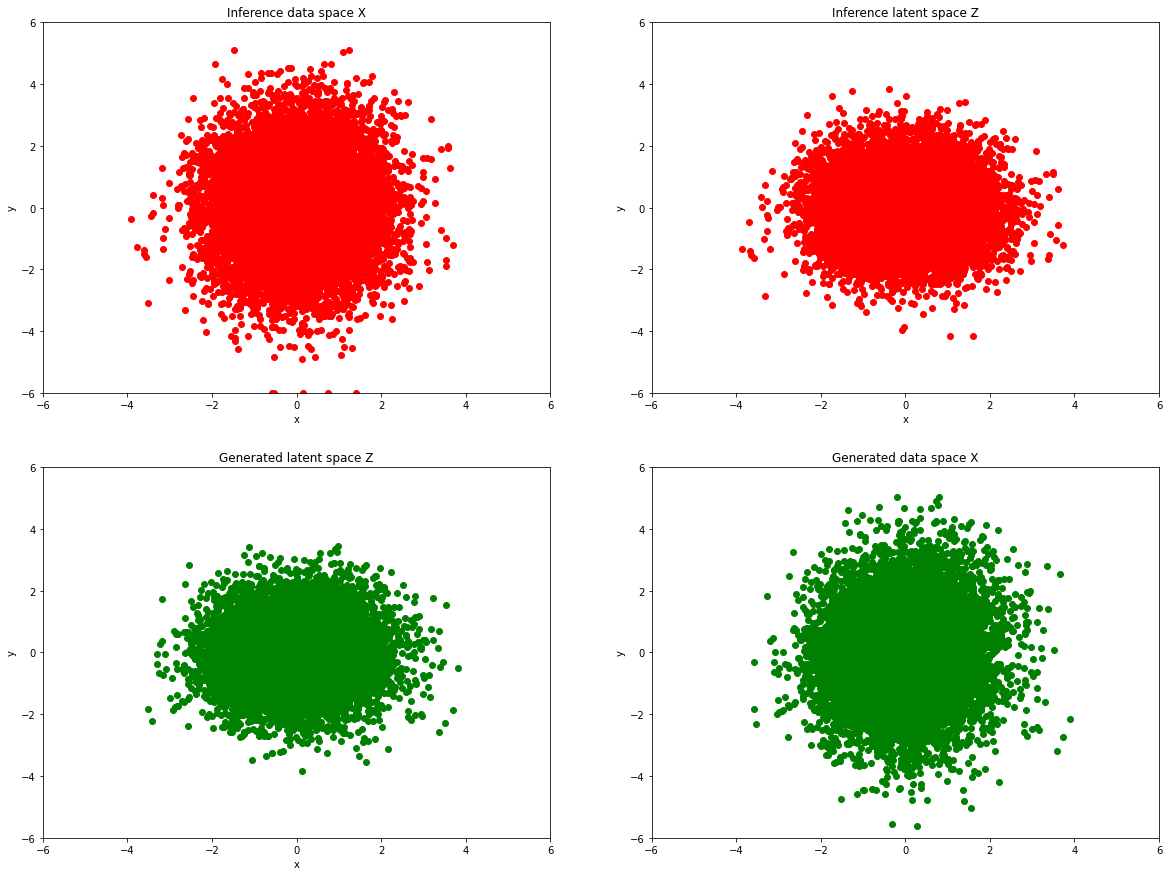

In [146]:
plt.figure(figsize=(15, 10))
plt.plot(marginal_history.history["loss"])
plt.plot(marginal_history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z, _ = marginal_model(marginal_data)

# From latent space to data.
samples = marginal_model.distribution.sample(10000)
x, _ = marginal_model.predict(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(marginal_data[:, 0], marginal_data[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 0].set_xlim([-6, 6])
axes[0, 0].set_ylim([-6, 6])
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-6, 6])
axes[0, 1].set_ylim([-6, 6])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 0].set_xlim([-6, 6])
axes[1, 0].set_ylim([-6, 6])
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-6, 6])
axes[1, 1].set_ylim([-6, 6])

In [147]:
x = np.linspace(-10, 10, 300)
y = np.linspace(-10, 10, 300)

xv, yv = np.meshgrid(x, y)

grid_data = np.stack([xv.flatten(), yv.flatten()], axis=-1)

In [148]:
z_joint, logdet_joint = joint_model(grid_data)
log_prob_x_joint = joint_model.distribution.log_prob(z_joint) + logdet_joint

z_marginal, logdet_marginal = marginal_model(grid_data)
log_prob_x_marginal = marginal_model.distribution.log_prob(z_marginal) + logdet_marginal

In [149]:
prob_x_joint = tf.exp(log_prob_x_joint)
prob_x_marginal = tf.exp(log_prob_x_marginal)

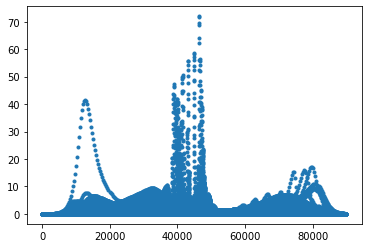

In [150]:
plt.plot(prob_x_joint / (prob_x_marginal + 1e-8), ".")

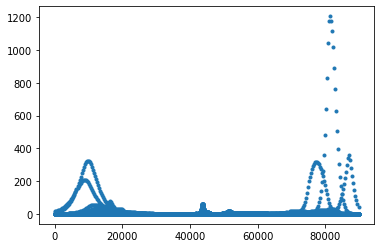

In [151]:
plt.plot(prob_x_marginal / (prob_x_joint + 1e-8), ".")

In [152]:
(20 / 300) * (20 / 300) * np.sum(prob_x_joint)

0.9932443576388889

# Train MMSE

In [153]:
class NN_function(tf.keras.Model): 
    # Use class to produce joint distribution and product of marginals
    def __init__(self, hidden_dim, layers, activation, **extra_kwargs):
        super(NN_function, self).__init__()
        self._f = tf.keras.Sequential(
          [tf.keras.layers.Dense(hidden_dim, activation) for _ in range(layers)] +
          [tf.keras.layers.Dense(1)])

    def call(self, x, y):
        batch_size = tf.shape(x)[0]
        x_tiled = tf.tile(x[None, :],  (batch_size, 1, 1))
        y_tiled = tf.tile(y[:, None],  (1, batch_size, 1))
        xy_pairs = tf.reshape(tf.concat((x_tiled, y_tiled), axis=2), [batch_size * batch_size, -1])
        scores = self._f(xy_pairs)
        return tf.transpose(tf.reshape(scores, [batch_size, batch_size]))


def joint_marginal_batch(x, noise):
    y = x + noise

    batch_size = tf.shape(x)[0]
    x_tiled = tf.tile(x[None, :],  (batch_size, 1, 1))
    y_tiled = tf.tile(y[:, None],  (1, batch_size, 1))
    xy_pairs = tf.reshape(tf.concat((x_tiled, y_tiled), axis=2), [batch_size * batch_size, -1]).numpy()

    joint_data = xy_pairs.copy()
    marginal_data = np.stack([shuffle(xy_pairs[:,0]), shuffle(xy_pairs[:,1])], axis=-1)
    
    return joint_data, marginal_data

In [154]:
x_distribution = tfp.distributions.MultivariateNormalDiag(loc=[0.0],scale_diag=[1.0])
noise_distribution = tfp.distributions.MultivariateNormalDiag(loc=[0.0],scale_diag=[1.0])

In [155]:
L2 = 0.01

mmse_model = keras.models.Sequential(
    [
        keras.layers.Input(shape=(2,)),
        keras.layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(L2)),
        keras.layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(L2)),
        keras.layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(L2)),
        keras.layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(L2)),
        keras.layers.Dense(1),

    ]
)

In [156]:
h = 1.0

def mmse_loss(joint_data, marginal_data):
    
    z_joint, logdet_joint = joint_model(joint_data)
    log_prob_x_joint = joint_model.distribution.log_prob(z_joint) + logdet_joint
    prob_x_joint = tf.exp(log_prob_x_joint)
    
    z_marginal, logdet_marginal = marginal_model(marginal_data)
    log_prob_x_marginal = marginal_model.distribution.log_prob(z_marginal) + logdet_marginal
    prob_x_marginal = tf.exp(log_prob_x_marginal)
    
    k_proportion = prob_x_marginal / (prob_x_joint + 1e-8)
    
    
    mmse_model_output_joint = tf.squeeze(mmse_model(joint_data), axis=-1)
    mmse_model_output_marginal = tf.squeeze(mmse_model(marginal_data), axis=-1)
    
    
    batch_loss = 1 / h**2 * (mmse_model_output_joint - k_proportion * tf.exp(mmse_model_output_marginal) / tf.reduce_mean(tf.exp(mmse_model_output_marginal)))
    
    return tf.abs(tf.reduce_mean(batch_loss))

In [157]:
joint_data, marginal_data = joint_marginal_batch(x_distribution.sample(128), noise_distribution.sample(128))

In [158]:
mmse_loss(joint_data, marginal_data)

<tf.Tensor: shape=(), dtype=float32, numpy=2.3040357>

In [159]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=200,
    decay_rate=0.96,
    staircase=True)


loss_tracker = keras.metrics.Mean()
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [160]:
@tf.function
def train_step(joint_data, marginal_data):
    with tf.GradientTape() as tape:
        pure_loss_value = mmse_loss(joint_data, marginal_data)

        loss_value = pure_loss_value + sum(mmse_model.losses)
        
    grads = tape.gradient(loss_value, mmse_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, mmse_model.trainable_weights))

    loss_tracker.update_state(pure_loss_value)
    

@tf.function
def validation_step(joint_data, marginal_data):
    loss_value = mmse_loss(joint_data, marginal_data)
    
    loss_tracker.update_state(loss_value)

In [161]:
epochs = 50
batch_size = 128
nsample_train = 200 * batch_size
nsample_test = 50 * batch_size



train_x, train_noise = x_distribution.sample(nsample_train), noise_distribution.sample(nsample_train)
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_noise))
train_dataset = train_dataset.shuffle(10 ** 4).batch(batch_size).prefetch(tf.data.AUTOTUNE)


test_x, test_noise = x_distribution.sample(nsample_test),noise_distribution.sample(nsample_test)
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_noise))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


all_train_loss = []
all_validation_loss = []

for epoch in range(epochs):
    print(f"Epoch : {epoch + 1} / {epochs}")
    
    pbar = tqdm(train_dataset, total=nsample_train // batch_size)
    for x, noise in pbar:
        
        joint_data, marginal_data = joint_marginal_batch(x, noise)
        random_index = np.random.choice(batch_size * batch_size, 4 * batch_size)
        joint_data, marginal_data = joint_data[random_index], marginal_data[random_index]

        train_step(joint_data, marginal_data)
        
        pbar.set_description("Epoch %4d / %4d : Train Loss : ( %.4f )" % \
                             (epoch + 1, epochs, float(loss_tracker.result())))
    
    all_train_loss.append(float(loss_tracker.result()))
    loss_tracker.reset_states()
    
    
    pbar = tqdm(test_dataset, total=nsample_test // batch_size)
    for x, noise in pbar:
        
        joint_data, marginal_data = joint_marginal_batch(x, noise)
        random_index = np.random.choice(batch_size * batch_size, 4 * batch_size)
        joint_data, marginal_data = joint_data[random_index], marginal_data[random_index]
        
        validation_step(joint_data, marginal_data)
        
        pbar.set_description("Epoch %4d / %4d : Valid Loss : ( %.4f ) " % \
                             (epoch + 1, epochs, float(loss_tracker.result())))
    
    all_validation_loss.append(float(loss_tracker.result()))
    loss_tracker.reset_states()

Epoch : 1 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 2 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 3 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 4 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 5 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 6 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 7 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 8 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 9 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 10 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 11 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 12 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 13 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 14 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 15 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 16 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 17 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 18 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 19 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 20 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 21 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 22 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 23 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 24 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 25 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 26 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 27 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 28 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 29 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 30 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 31 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 32 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 33 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 34 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 35 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 36 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 37 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 38 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 39 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 40 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 41 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 42 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 43 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 44 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 45 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 46 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 47 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 48 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 49 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 50 / 50


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [162]:
def smooth(scalars: List[float], weight: float) -> List[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

Text(0.5, 0, 'epoch')

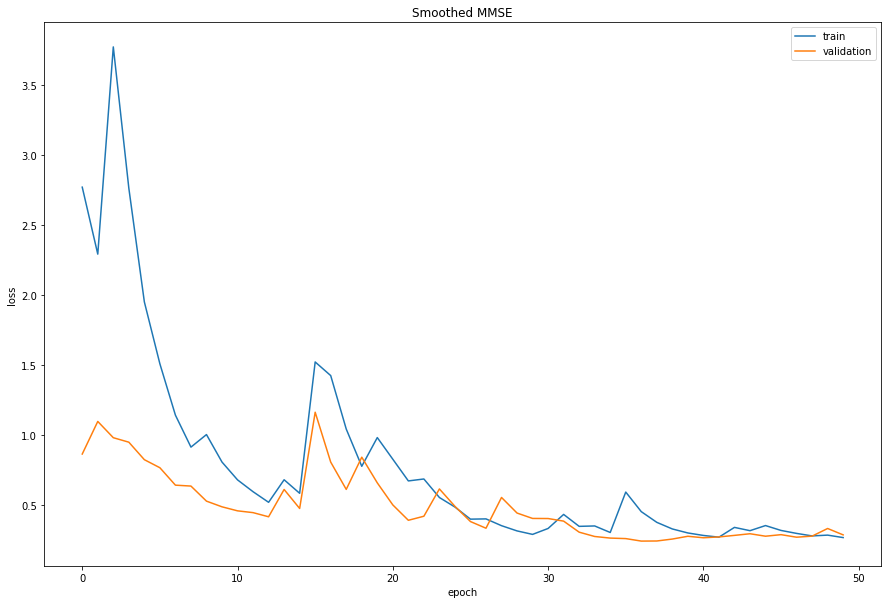

In [163]:
plt.figure(figsize=(15, 10))
plt.plot(smooth(all_train_loss, 0.6))
plt.plot(smooth(all_validation_loss, 0.6))
plt.title("Smoothed MMSE")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

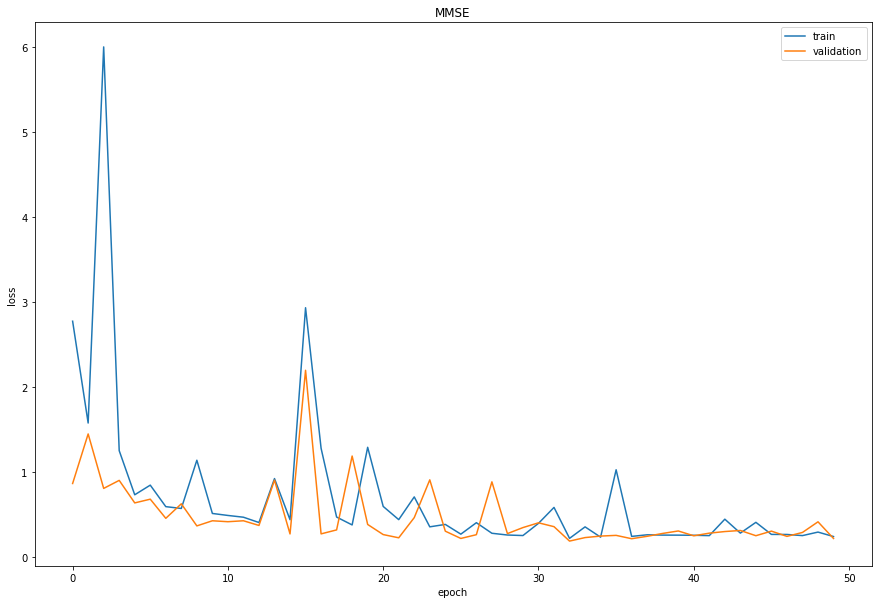

In [164]:
plt.figure(figsize=(15, 10))
plt.plot(all_train_loss)
plt.plot(all_validation_loss)
plt.title("MMSE")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

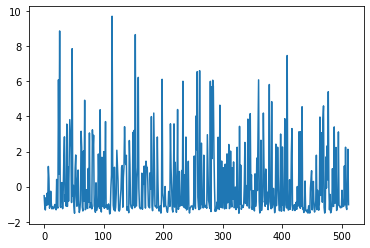

In [165]:
predicted = mmse_model(joint_data)
plt.plot(predicted)

In [166]:
mmse_model.save("models.h5")

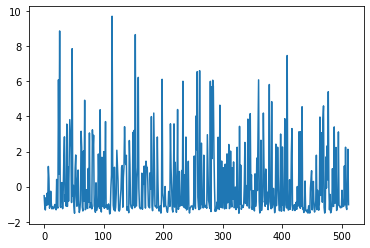

In [167]:
loaded_model = tf.keras.models.load_model("models.h5")
loaded_predicted = loaded_model(joint_data)
plt.plot(predicted)